In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
##import seaborn as sns
from urllib.parse import urlencode

Matplotlib is building the font cache; this may take a moment.


### *Работа с данными*

In [2]:
path = r'/drive/notebooks/test.csv'

In [3]:
df = pd.read_csv(path,sep='/') 
df.head()

,����,��������� �� ����� ������� �� ����,�������� �������
0,44742,1017,������ ����������
1,44730,1026,������ ����������
2,44725,1038,������ ����������
3,44730,1085,������ ����������
4,44736,1100,������ ����������


#### sep='/' - разделил текст на столбцы

In [4]:
new_column_names = {
    df.columns[0]: 'date',
    df.columns[1]: 'pacients',
    df.columns[2]: 'filial',
}

In [5]:
df.rename(columns=new_column_names, inplace=True)

In [6]:
df.shape

(1099, 3)

In [7]:
df.dtypes

date        object
pacients    object
filial      object
dtype: object

In [8]:
def convert_to_date(value):
    try:
        # Пробуем преобразовать значение в формат даты
        return pd.to_datetime(value, format='%d.%m.%y')
    except ValueError:
        try:
            # Если не получилось, пробуем преобразовать в число и затем в дату
            numeric_value = float(value)
            return pd.to_datetime(numeric_value, origin='1899-12-30', unit='D')
        except ValueError:
            # Если и это не получилось, возвращаем NaT (Not a Time)
            return pd.NaT

In [9]:
# Сохраняем исходные данные в новой колонке
df['original_dates'] = df['date']
# Преобразуем всю колонку в формат даты
df['date'] = df['date'].apply(convert_to_date)
# Переведем число пациентов в числительное
#df['pacients']=df['pacients'].astype(int)


In [10]:
def convert_to_int(value):
    """Преобразует значение в int, если возможно, иначе возвращает None."""
    try:
        # Пробуем преобразовать напрямую (для целых чисел в строке)
        return int(value)
    except (ValueError, TypeError):
        # Если не получилось - возвращаем None (можно заменить на 0 или np.nan)
        return None

In [11]:
df['original_pacients'] = df['pacients']
df['pacients'] = df['pacients'].apply(convert_to_int)

In [12]:
df.dtypes

date                 datetime64[ns]
pacients                    float64
filial                       object
original_dates               object
original_pacients            object
dtype: object

In [13]:
#df['pacients']=df['pacients'].astype(int)

In [14]:
#посмотрим на ошибки
ndf=df[df['date'].isna()]
ndf

,date,pacients,filial,original_dates,original_pacients
290,NaT,2357.0,������ ����������,07.O7.2022,2357
610,NaT,2726.0,������ ����������,��.11.2022,2726


_Из-за ошибки в данных дату второй записи восстановить невозможно (ошибка не в кодировке, в оригинале стоит пп.11.2022)_

In [15]:
df.head()

,date,pacients,filial,original_dates,original_pacients
0,2022-06-30,1017.0,������ ����������,44742,1017
1,2022-06-18,1026.0,������ ����������,44730,1026
2,2022-06-13,1038.0,������ ����������,44725,1038
3,2022-06-18,1085.0,������ ����������,44730,1085
4,2022-06-24,1100.0,������ ����������,44736,1100


In [16]:
#заменим значение в ячейке
df.loc[290, 'date'] = pd.to_datetime('2022-07-07') 

In [17]:
ndf=df[df['date'].isna()]
ndf

,date,pacients,filial,original_dates,original_pacients
610,NaT,2726.0,������ ����������,��.11.2022,2726


In [18]:
df=df.dropna(subset=['date'])

In [19]:
#Проверим на Nan колонку с пациентами
pdf=df[df['pacients'].isna()]
pdf

,date,pacients,filial,original_dates,original_pacients
1097,2022-09-20,NaN,������ ����������,44824,293�5
1098,2022-05-13,NaN,������ ����������,44694,�083


_Предпологаю, что в первом случае опечатка и это должно было быть 2935, второй либо 1083 либо 2083. Либо делать запрос на уточнение данных либо удалять строки_

In [20]:
df=df.dropna(subset=['pacients'])

In [21]:
df.shape

(1096, 5)

In [22]:
df.head()

,date,pacients,filial,original_dates,original_pacients
0,2022-06-30,1017.0,������ ����������,44742,1017
1,2022-06-18,1026.0,������ ����������,44730,1026
2,2022-06-13,1038.0,������ ����������,44725,1038
3,2022-06-18,1085.0,������ ����������,44730,1085
4,2022-06-24,1100.0,������ ����������,44736,1100


_Так как у меня есть совпадающие даты, то можно условно сопоставить количество пациентов и филиалы, которые они посетили в эту дату_

In [23]:
df['filial'] = df.groupby('date').cumcount() + 1  # Нумерация: 1, 2, 3...
df['filial'] = 'Филиал ' + df['filial'].astype(str)

In [24]:
df.head()

,date,pacients,filial,original_dates,original_pacients
0,2022-06-30,1017.0,Филиал 1,44742,1017
1,2022-06-18,1026.0,Филиал 1,44730,1026
2,2022-06-13,1038.0,Филиал 1,44725,1038
3,2022-06-18,1085.0,Филиал 2,44730,1085
4,2022-06-24,1100.0,Филиал 1,44736,1100


In [25]:
df.filial.unique()

array(['Филиал 1', 'Филиал 2', 'Филиал 3', 'Филиал 4', 'Филиал 5',
       'Филиал 6', 'Филиал 7', 'Филиал 8', 'Филиал 9', 'Филиал 10'],
      dtype=object)

_многовато, посмотрим внимательнее_

In [26]:
df['filial'].value_counts()

filial
Филиал 1     370
Филиал 2     309
Филиал 3     199
Филиал 4     111
Филиал 5      70
Филиал 6      24
Филиал 7       9
Филиал 8       2
Филиал 9       1
Филиал 10      1
Name: count, dtype: int64

In [27]:
filter_df = df[df['filial'].str.match(r'Филиал (6|7|8|9|10)')]

In [28]:
filter_df

,date,pacients,filial,original_dates,original_pacients
58,2022-12-20,1987.0,Филиал 6,44915,1987
71,2022-12-20,2065.0,Филиал 7,44915,2065
336,2022-08-17,2399.0,Филиал 6,44790,2399
358,2022-08-17,2421.0,Филиал 7,44790,2421
390,2022-01-20,2446.0,Филиал 6,44581,2446
446,2022-01-17,2508.0,Филиал 6,44578,2508
452,2022-02-02,2511.0,Филиал 6,44594,2511
463,2022-08-23,2529.0,Филиал 6,44796,2529
466,2022-08-06,2534.0,Филиал 6,44779,2534
471,2022-01-19,2537.0,Филиал 6,44580,2537


_Посмотрим распределение за все данные вообще и выведем среднее, определим пиковые значения_

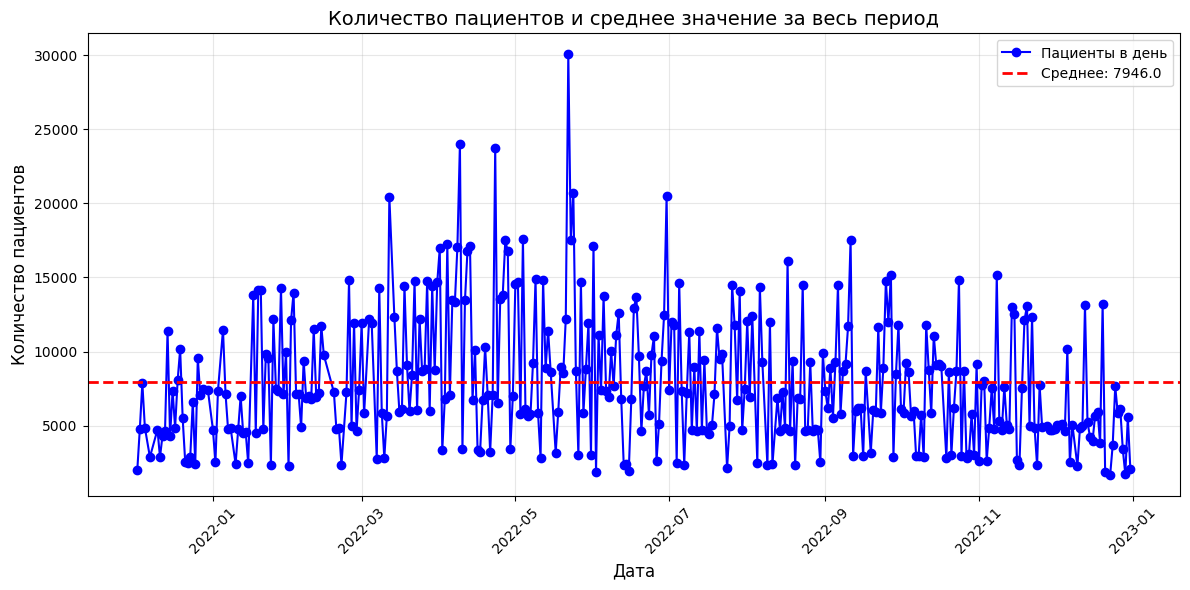

In [29]:
ddf = df.groupby('date')['pacients'].sum().reset_index()
# Рассчитываем среднее
mean_value = ddf['pacients'].mean()
# Создаем график
plt.figure(figsize=(12, 6))
plt.plot(ddf['date'], ddf['pacients'], 
         marker='o', 
         linestyle='-', 
         color='blue',
         label='Пациенты в день')
# Выведу среднее
plt.axhline(y=mean_value, 
            color='red', 
            linestyle='--', 
            linewidth=2,
            label=f'Среднее: {mean_value:.1f}')

plt.title('Количество пациентов и среднее значение за весь период', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

_Наблюдаю явные выбросы. 22.05.22 -дата что сильно выбивается как на графике, так и по количеству филиалов в день. 9 и 10й филиалы встречаются единожды в эту дату. Возможная ошибка сбора данных/они подали данные за определенный период работы, либо сработала какая-то маркетинговая акция (согласно истории поиска в апреле мае проходили акции по повышению привлекательности мобильного приложения_

In [30]:
df22 = df.query("date == '2022-05-22'")
df22

<ipython-input-30-adc16aa27b66>:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df22 = df.query("date == '2022-05-22'")


,date,pacients,filial,original_dates,original_pacients
712,2022-05-22,2855.0,Филиал 1,44703,2855
730,2022-05-22,2874.0,Филиал 2,44703,2874
746,2022-05-22,2896.0,Филиал 3,44703,2896
765,2022-05-22,2926.0,Филиал 4,44703,2926
787,2022-05-22,2952.0,Филиал 5,44703,2952
868,2022-05-22,3058.0,Филиал 6,44703,3058
906,2022-05-22,3104.0,Филиал 7,44703,3104
915,2022-05-22,3119.0,Филиал 8,44703,3119
925,2022-05-22,3130.0,Филиал 9,44703,3130
945,2022-05-22,3153.0,Филиал 10,44703,3153


### Работа с 2022г.

In [31]:
df_2022 = df[df['date'].dt.year == 2022]
df_2022.head()

,date,pacients,filial,original_dates,original_pacients
0,2022-06-30,1017.0,Филиал 1,44742,1017
1,2022-06-18,1026.0,Филиал 1,44730,1026
2,2022-06-13,1038.0,Филиал 1,44725,1038
3,2022-06-18,1085.0,Филиал 2,44730,1085
4,2022-06-24,1100.0,Филиал 1,44736,1100


In [32]:
df_2022.shape

(1039, 5)

In [33]:
df_2022.dtypes

date                 datetime64[ns]
pacients                    float64
filial                       object
original_dates               object
original_pacients            object
dtype: object

In [34]:
#Количество пациентов в день
daily_paсients = df_2022.groupby('date').aggregate({'pacients':'sum'}).reset_index()

In [35]:
daily_paсients.head()

,date,pacients
0,2022-01-01,4730.0
1,2022-01-02,2521.0
2,2022-01-03,7356.0
3,2022-01-05,11467.0
4,2022-01-06,7153.0


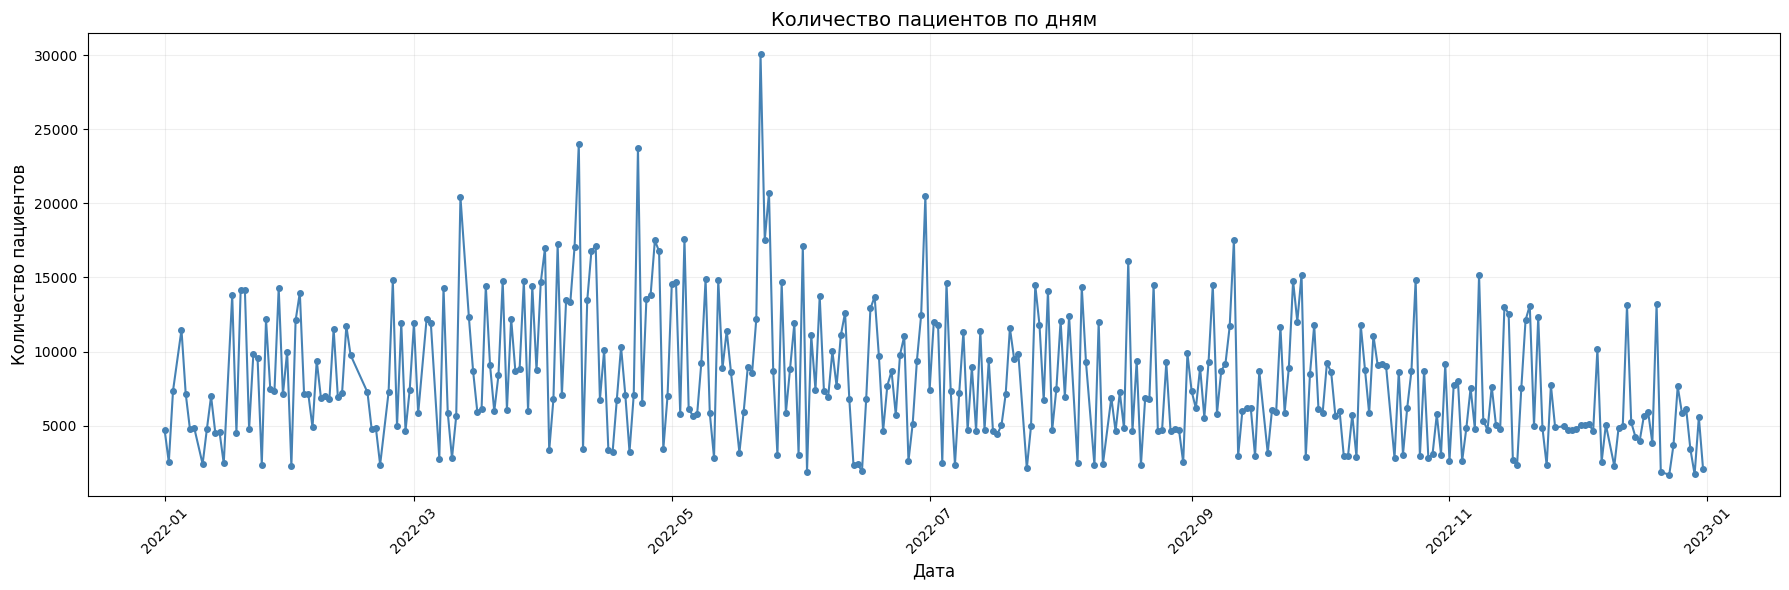

In [36]:
plt.figure(figsize=(18, 6))
plt.plot(daily_paсients['date'], daily_paсients['pacients'], 
         marker='o', 
         linestyle='-',
         color='steelblue',
         markersize=4)

plt.title('Количество пациентов по дням', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.grid(True, alpha=0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

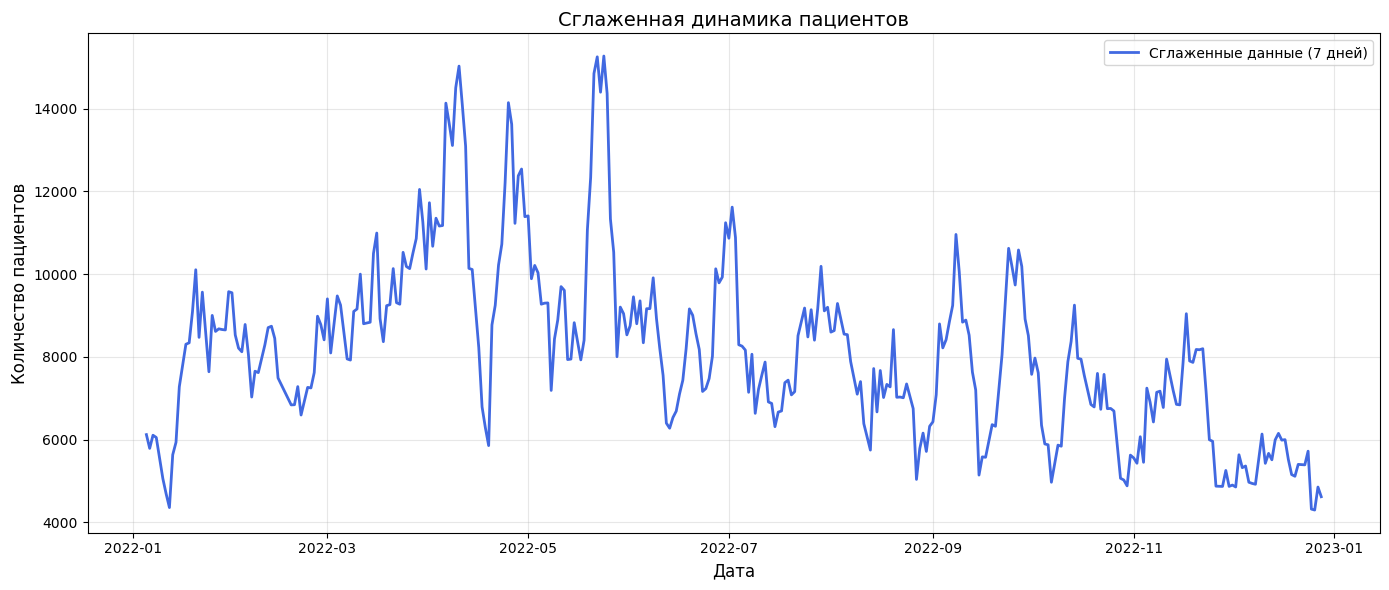

In [37]:
plt.figure(figsize=(14, 6))

# Добавляем скользящее среднее за 7 дней
daily_paсients['smooth'] = daily_paсients['pacients'].rolling(7, center=True).mean()

plt.plot(daily_paсients['date'], daily_paсients['smooth'], 
         color='royalblue',
         linewidth=2,
         label='Сглаженные данные (7 дней)')

plt.title('Сглаженная динамика пациентов', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
print("Среднее:", daily_paсients['pacients'].mean())
print("Медиана:", daily_paсients['pacients'].median())

Среднее: 8119.298550724638
Медиана: 7117.0


In [43]:
from scipy import stats
print(stats.shapiro(daily_paсients['pacients']))

ShapiroResult(statistic=np.float64(0.9287885543048632), pvalue=np.float64(9.11109174909077e-12))


In [44]:
#Теперь по месяцам 
daily_paсients['month'] = daily_paсients['date'].dt.to_period('M')
monthly_paсients = daily_paсients.groupby('month')['pacients'].sum().reset_index()
monthly_paсients.head()

,month,pacients
0,2022-01,202228.0
1,2022-02,192588.0
2,2022-03,273600.0
3,2022-04,330219.0
4,2022-05,309910.0


In [45]:
#вернул значения времени, а не периода для построения графика
monthly_paсients['month'] = monthly_paсients['month'].dt.to_timestamp()

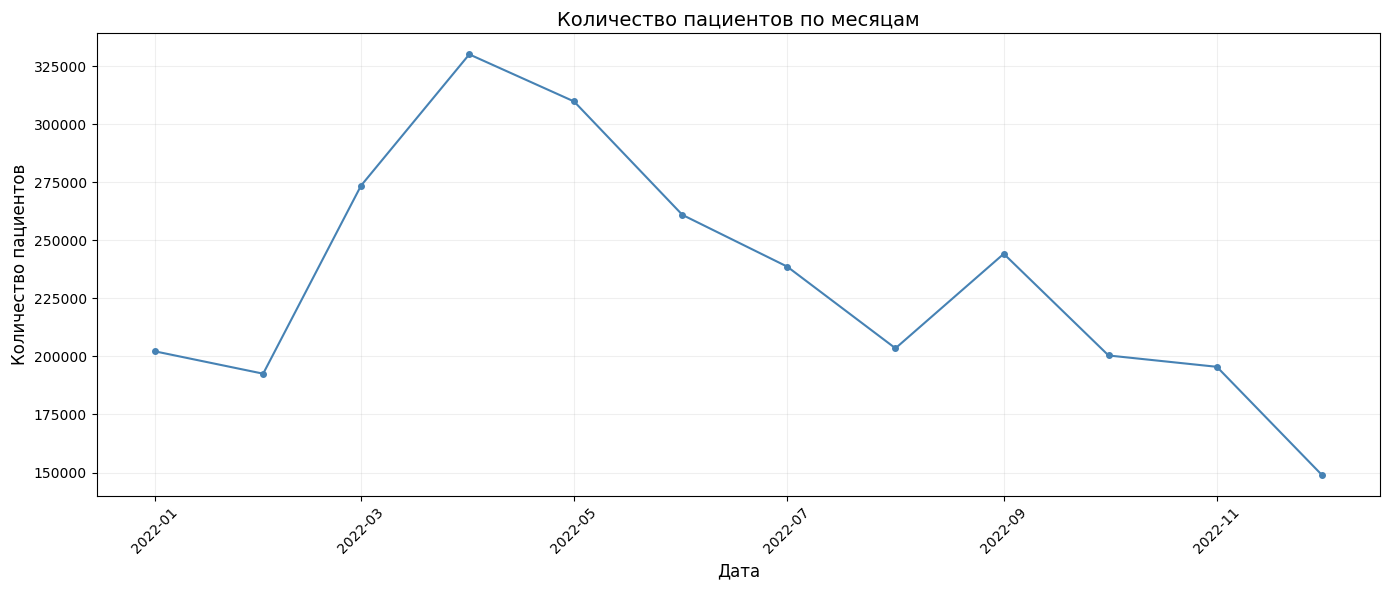

In [46]:
plt.figure(figsize=(14, 6))
plt.plot(monthly_paсients['month'], monthly_paсients['pacients'], 
         marker='o', 
         linestyle='-',
         color='steelblue',
         markersize=4)

plt.title('Количество пациентов по месяцам', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.grid(True, alpha=0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

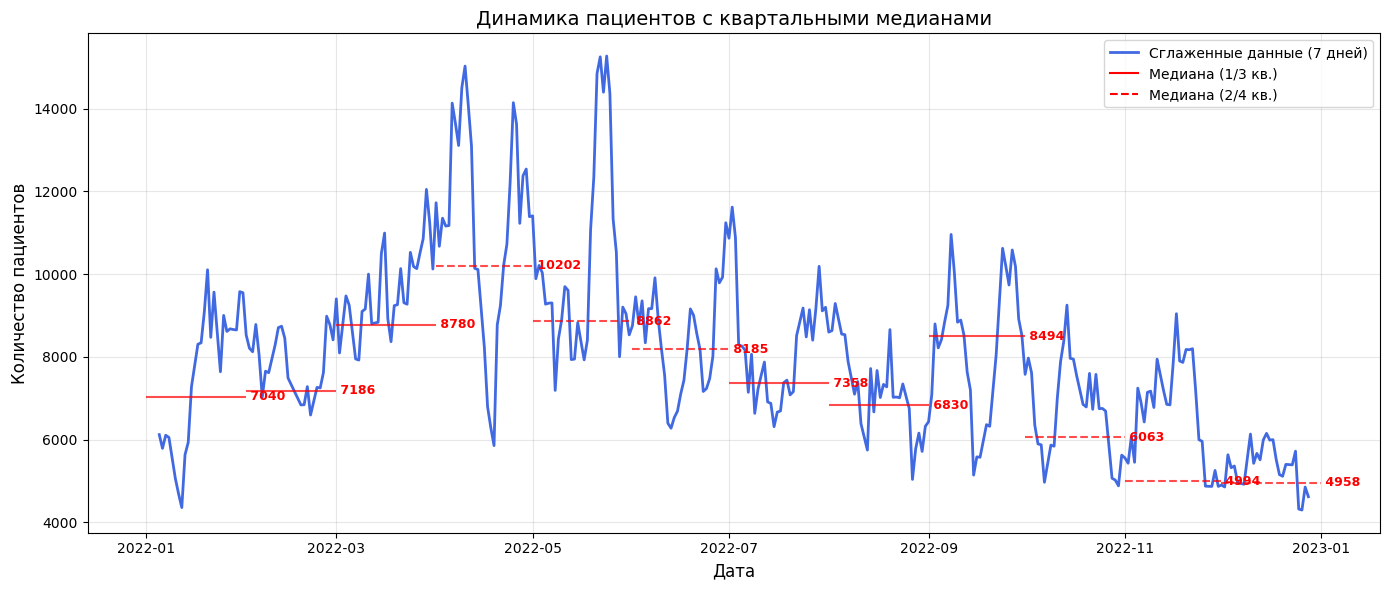

In [47]:
plt.figure(figsize=(14, 6))

# Сглаживание данных
daily_paсients['smooth'] = daily_paсients['pacients'].rolling(7, center=True).mean()

# Основной график
plt.plot(daily_paсients['date'], daily_paсients['smooth'], 
         color='royalblue',
         linewidth=2,
         label='Сглаженные данные (7 дней)')

# Месячные медианы
monthly_medians = daily_paсients.groupby(daily_paсients['date'].dt.to_period('M'))['pacients'].median()

for month, median_val in monthly_medians.items():
    month_start = month.to_timestamp()
    month_end = (month + 1).to_timestamp()
    
    # Определяем стиль линии по кварталу
    line_style = '-' if month.quarter in [1,3] else '--'
    
    plt.hlines(y=median_val,
               xmin=month_start,
               xmax=month_end,
               colors='red',
               linewidth=1.5,
               alpha=0.7,
               linestyle=line_style,
               label='Медиана' if month == monthly_medians.index[0] else "")

    # Числовые значения медиан
    plt.text(month_end, 
             median_val, 
             f' {median_val:.0f}',
             ha='left', 
             va='center', 
             color='red',
             fontsize=9,
             fontweight='bold')

# Настройка легенды (убираем дубликаты)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Создаем кастомные элементы для легенды
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='royalblue', lw=2),
                Line2D([0], [0], color='red', lw=1.5, linestyle='-'),
                Line2D([0], [0], color='red', lw=1.5, linestyle='--')]

plt.legend(custom_lines, 
           ['Сглаженные данные (7 дней)', 'Медиана (1/3 кв.)', 'Медиана (2/4 кв.)'],
           loc='upper right')

# Оформление
plt.title('Динамика пациентов с квартальными медианами', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### *Вывод*

**Согласно предоставленным данным, можем наблюдать сезонные наплывы клиентов с марта по май и в сентябре. Предполагаю, что в период с марта по апрель так же была сезонная акция в связи с раскруткой мобильного приложения и открытия новых филиалов, что дополнительно подстегнуло интерес пользователей к услуга сети клиник. Для более полного анализа стоит отранжировать пользователей по специфике посещения (новые, постоянные, по полису дмс от работы, приглашенные по акции). С июня по август плато\тенденция спада, что можно соотнести с летними отпусками и окончанием эффекта от маркетинговых акций. Сентябрь - конец сезона отпусков, с октября и по конец года - плато посещаемости и самые низкие значения по количеству клиентов. Возможно стоит подготовить предновогодние акции "В новый год со сверкающей улыбкой!".**